# Create and map shapefule of IVT catchments (merging LSOAs)

Identify LSOAs within each IVT catchment and show as a map.

To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb

Trying to delete inner lines of merged polygons so can use an outline, but no success as yet. One of the resources tried: https://stackoverflow.com/questions/59797292/deleting-inner-lines-of-polygons-after-dissolving-in-geopandas

https://stackoverflow.com/questions/59797292/deleting-inner-lines-of-polygons-after-dissolving-in-geopandas

Import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import os
from matplotlib.transforms import Bbox
import matplotlib.colors as colors
import random
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mapclassify import __version__, greedy # adjacent polygons different colours

Read in data for closest IVT per LSOA

In [2]:
df_lsoa = pd.read_csv('./data/collated_data.csv')

Look at first few rows

In [3]:
df_lsoa.head()

LSOA  admissions closest_ivt_unit  closest_ivt_unit_time  \
0  Welwyn Hatfield 010F    0.666667           SG14AB                   19.2   
1  Welwyn Hatfield 012A    4.000000           SG14AB                   20.3   
2  Welwyn Hatfield 002F    2.000000           SG14AB                   19.2   
3  Welwyn Hatfield 002E    0.666667           SG14AB                   19.2   
4  Welwyn Hatfield 010A    3.333333           SG14AB                   19.2   

  closest_mt_unit  closest_mt_unit_time  mt_transfer_time  ivt_rate  \
0          NW12BU                  37.5              47.2       6.8   
1          NW12BU                  37.5              47.2       6.8   
2          NW12BU                  38.6              47.2       6.8   
3          NW12BU                  37.5              47.2       6.8   
4          NW12BU                  37.5              47.2       6.8   

   IMD2019Score Local Authority District name (2019)  ...  age band males 50  \
0        15.616                      Welwyn Hatfield  ...               53.0   
1        33.313                      Welwyn Hatfield  ...               58.0   
2         7.043                      Welwyn Hatfield  ...               43.0   
3         8.249                      Welwyn Hatfield  ...               42.0   
4        19.271                      Welwyn Hatfield  ...               56.0   

   age band males 55  age band males 60  age band males 65  age band males 70  \
0               62.0               37.0               32.0               27.0   
1               63.0               43.0               36.0               25.0   
2               50.0               51.0               21.0               31.0   
3               63.0               33.0               20.0               15.0   
4               54.0               37.0               32.0               28.0   

   age band males 75  age band males 80  age band males 85  age band males 90  \
0               30.0               15.0                4.0                3.0   
1               14.0               15.0                9.0                7.0   
2                8.0                5.0                8.0                5.0   
3               18.0               18.0                5.0                1.0   
4               21.0               12.0                9.0                2.0   

   age band males 95  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  

[5 rows x 140 columns]

Load LSOA shape file

The following will load the shape file of the England and Wales LSOA (Lower Super Output Areas) into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings).

Other crs to consider for other data projections:
* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
* EPSG:3857 - projection for displaying lat/long as a flat map

In [4]:
filename = 'zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip'
gdf_lsoa = gpd.read_file(filename, crs='EPSG:27700')
gdf_lsoa.head()

LSOA11CD                   LSOA11NM                  LSOA11NMW  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

                                            geometry  
0  POLYGON ((532105.092 182011.230, 532162.491 18...  
1  POLYGON ((532746.813 181786.891, 532671.688 18...  
2  POLYGON ((532135.145 182198.119, 532158.250 18...  
3  POLYGON ((533807.946 180767.770, 533649.063 18...  
4  POLYGON ((545122.049 184314.931, 545271.917 18...

View a simple map of this data.

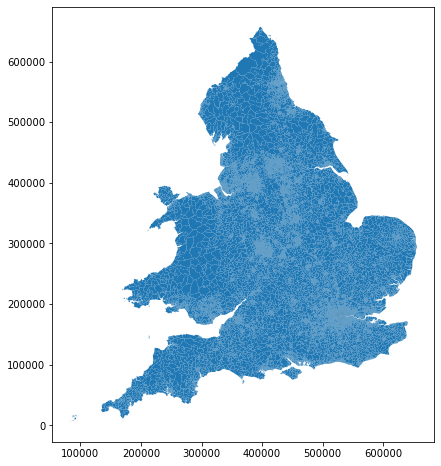

In [5]:
gdf_lsoa.plot(figsize=(8,8));

### Merging areas together

Let's create a shapefile for the IVT catchment areas. Merge LSOA polygons that are in the same IVT unit catchment (we can merge on any column in order to combine areas). This will create a new DataFrame. To merge areas we use the dissolve() method.

https://geopandas.org/aggregation_with_dissolve.html

First need to add a column to the geopandas dataframe. Using LSOA as the common value, bring in the field 'closest_ivt_unit'

Match gdf_lsoa['LSOA11NMW'] with df_lsoa['LSOA'] and add df_lsoa['closest_ivt_unit'] to gdf_lsoa['closest_ivt_unit'].

https://stackoverflow.com/questions/39816671/pandas-populate-new-dataframe-column-based-on-matching-columns-in-another-datafr

In [6]:
filename = "data/ivt_catchment.shp"
exist = os.path.exists(filename)

if exist:
    # Read in
    gdf_ivt_catchment = gpd.read_file(filename, crs='EPSG:27700')
    # saving a shapefile restricts column titles to 10 characters
    col = 'closest_iv'
    gdf_ivt_catchment.set_index(col, inplace=True)
else:
    # Create IVT catchment shapefile by dissolving LSOA polygons
    
    # Set index for the two data files
    df_lsoa.set_index(['LSOA'], inplace=True)
    gdf_lsoa.set_index(['LSOA11NM'], inplace=True)
    # Saving a shapefile restricts column titles to 10 characters, but here we have original column title
    col = 'closest_ivt_unit'
    gdf_lsoa = gdf_lsoa.join(df_lsoa[col]).reset_index()
    
    # Next bit ensures that there are no inner lines (from the original polygons)
    #   after dissolving in geopandas
    #   (see https://stackoverflow.com/questions/59797292/deleting-inner-lines-
    #    of-polygons-after-dissolving-in-geopandas)
    gdf_lsoa['geometry'] = gdf_lsoa['geometry'].buffer(0.0001)

    # Now merge on closest ivt unit (those polygons with the same closest IVT unit will become a single polygon.
    gdf_ivt_catchment = gdf_lsoa.dissolve(by='closest_ivt_unit')#, aggfunc='sum'
    
    # Save a shapefile of the catchments for each IVT
    gdf_ivt_catchment.to_file("data/ivt_catchment.shp")

Take a look at the shapefile of the IVT catchments

In [7]:
gdf_ivt_catchment.head()

LSOA11NM   LSOA11CD  \
closest_iv                                                 
B152TH                        Birmingham 067A  E01008881   
B714HJ                        Birmingham 037A  E01008899   
BA13NG      Bath and North East Somerset 007A  E01014370   
BA214AT                       East Devon 005A  E01019886   
BB23HH                            Bolton 001B  E01004803   

                                    LSOA11NMW  \
closest_iv                                      
B152TH                        Birmingham 067A   
B714HJ                        Birmingham 037A   
BA13NG      Bath and North East Somerset 007A   
BA214AT                       East Devon 005A   
BB23HH                            Bolton 001B   

                                                     geometry  
closest_iv                                                     
B152TH      MULTIPOLYGON (((416346.099 267790.717, 416204....  
B714HJ      MULTIPOLYGON (((417917.557 275983.465, 418024....  
BA13NG      MULTIPOLYGON (((391028.906 148190.250, 391138....  
BA214AT     MULTIPOLYGON (((325347.501 91556.700, 325347.5...  
BB23HH      POLYGON ((378922.528 421439.886, 378922.528 42...

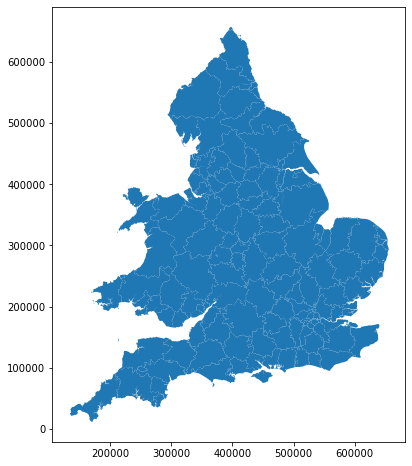

In [8]:
gdf_ivt_catchment.plot(figsize=(8,8));

## Create catchment map

Using MatPlotLib gives us more power than the GeoPandas DataFrame plot method.
Create a map showing the location of the IVT units, and their catchments (as defined by the group of LSOAs that are nearest to each IVT unit)

Read in hospital data
(Stroke Team, SSNAP name, Easting, Northing)

In [9]:
gdf_units = gpd.read_file('./data/stroke_hospitals_2022.csv')

# Define the geometry fields
gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)

# Set co-ordinate reference system
gdf_units = gdf_units.set_crs(epsg=27700)

# Limit to those that deliver IVT
mask = gdf_units['Use_IVT']=="1"
gdf_units = gdf_units[mask]
gdf_units.head()

Postcode Hospital_name Use_IVT Use_MT  Country Strategic Clinical Network  \
0   RM70AG        RM70AG       1      1  England                 London SCN   
1    E11BB         E11BB       1      1  England                 London SCN   
2   SW66SX        SW66SX       1      1  England                 London SCN   
3   SE59RW        SE59RW       1      1  England                 London SCN   
4   BR68ND        BR68ND       1      0  England                 London SCN   

                                Health Board / Trust  \
0  Barking; Havering and Redbridge University Hos...   
1                             Barts Health NHS Trust   
2              Imperial College Healthcare NHS Trust   
3       King's College Hospital NHS Foundation Trust   
4       King's College Hospital NHS Foundation Trust   

                                     Stroke Team  \
0                      Queen's Hospital, Romford   
1                      The Royal London Hospital   
2                 Charing Cross Hospital, London   
3                King's College Hospital, London   
4  Princess Royal University Hospital; Orpington   

                                SSNAP name Admissions 21/22 Thrombolysis  \
0             Queens Hospital Romford HASU              981          117   
1               Royal London Hospital HASU              861          115   
2              Charing Cross Hospital HASU             1147          113   
3             King's College Hospital HASU              824          124   
4  Princess Royal University Hospital HASU              847          113   

  ivt_rate Easting Northing Neuroscience 30 England Thrombectomy Example  \
0     11.9  551118   187780            1                               0   
1     13.4  534829   181798            1                               1   
2      9.9  524226   176487            1                               1   
3       15  532536   176228            1                               0   
4     13.3  543443   165032            0                               0   

    hospital_city Notes                       geometry  
0         Romford        POINT (551118.000 187780.000)  
1    Royal London        POINT (534829.000 181798.000)  
2   Charing Cross        POINT (524226.000 176487.000)  
3   Kings College        POINT (532536.000 176228.000)  
4  Princess Royal        POINT (543443.000 165032.000)

In [10]:
# When using base maps convert data to epsg:3857
gdf_ivt_catchment = gdf_ivt_catchment.to_crs(epsg=3857)
gdf_units = gdf_units.to_crs(epsg=3857)

In [11]:
def add_nonoverlapping_text_labels(gdf_units, ax, col, y_step=0.05, fontsize=7):
    """
    #https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position


    """

    text_rectangles = []

    # Better results if the labels are sorted descending in the y axis
    gdf_units['sort_by'] = gdf_units.geometry.y
    gdf_units.sort_values("sort_by", ascending=False, inplace=True)
    del gdf_units["sort_by"]

    # Add labels
    for x, y, label in zip(
        gdf_units.geometry.x, gdf_units.geometry.y, gdf_units[col]):
            text = ax.annotate(label, xy=(x, y), xytext=(8, 8), 
                        textcoords="offset points", fontsize=fontsize, 
                        bbox=dict(facecolor='w', alpha=0.3, edgecolor='none', boxstyle="round", pad=0.1))
            x, y = text.get_position()
            new_x = x - 2
            text.set_position((new_x, y))
                    
            rect = text.get_window_extent()

            for other_rect in text_rectangles:
                while Bbox.intersection(rect, other_rect):  # overlapping
                    x, y = text.get_position()
                    new_y = y - y_step
                    text.set_position((x, new_y))
                    rect = text.get_window_extent()
            text_rectangles.append(rect)
    return (ax)

## Create data to add an inset map for London

https://jeremysze.github.io/GIS_exploration/build/html/zoomed_inset_axes.html
https://matplotlib.org/3.1.1/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.zoomed_inset_axes.html

In [12]:
eng_wales_bounds = gdf_ivt_catchment.reset_index(level=0).bounds
eng_wales_bounds.reset_index(level=0, inplace=True)
eng_wales_bounds.head()

index           minx          miny           maxx          maxy
0      0 -228159.802962  6.840962e+06 -186486.338536  6.891316e+06
1      1 -229569.237502  6.866385e+06 -174024.968174  6.928042e+06
2      2 -301440.775912  6.639528e+06 -219298.476507  6.742989e+06
3      3 -343008.663893  6.568119e+06 -236217.122688  6.661788e+06
4      4 -294540.971643  7.097870e+06 -227656.460963  7.179456e+06

In [13]:
eng_wales_bounds = eng_wales_bounds.merge(gdf_ivt_catchment.reset_index(level=0)[col],how = 'left',
                      left_on = eng_wales_bounds.index,
                      right_on = gdf_ivt_catchment.reset_index(level=0).index)

In [14]:
eng_wales_bounds.drop('key_0', axis = 1, inplace = True)
eng_wales_bounds.set_index(col, inplace=True)
eng_wales_bounds.head()

index           minx          miny           maxx          maxy
closest_iv                                                                 
B152TH          0 -228159.802962  6.840962e+06 -186486.338536  6.891316e+06
B714HJ          1 -229569.237502  6.866385e+06 -174024.968174  6.928042e+06
BA13NG          2 -301440.775912  6.639528e+06 -219298.476507  6.742989e+06
BA214AT         3 -343008.663893  6.568119e+06 -236217.122688  6.661788e+06
BB23HH          4 -294540.971643  7.097870e+06 -227656.460963  7.179456e+06

Resource used for unique colour polygons
https://stackoverflow.com/questions/73972753/how-to-fill-polygons-with-unique-color-in-python-matplotlib

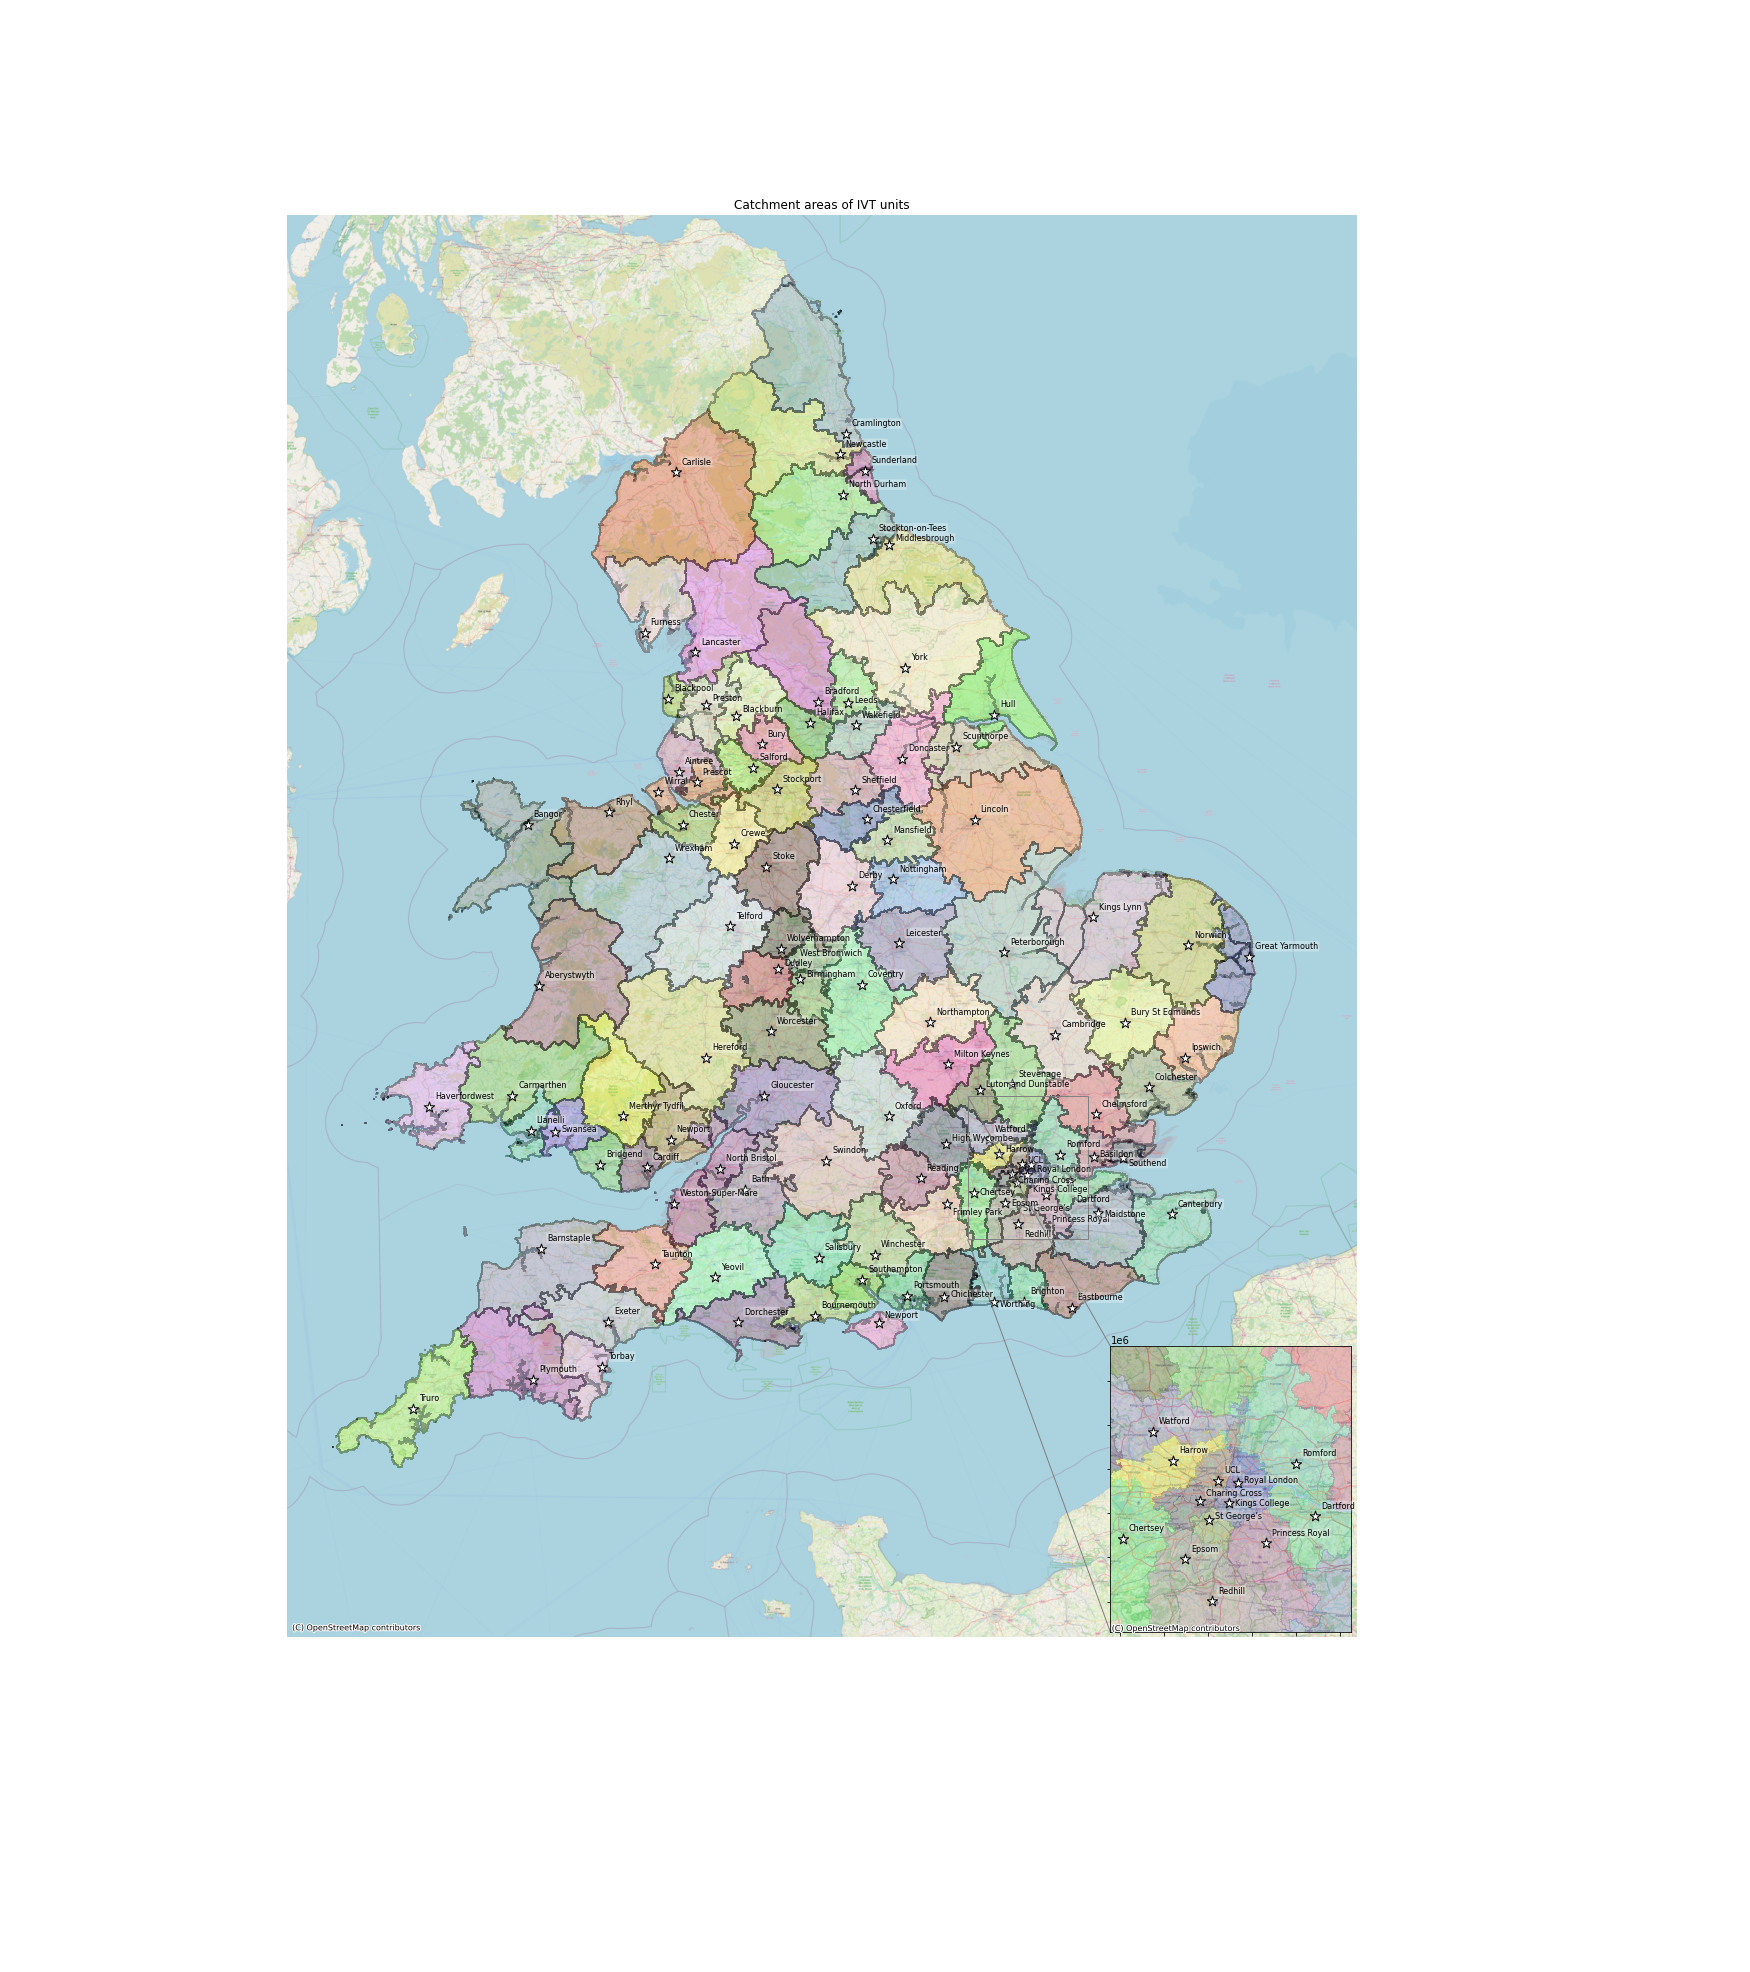

In [15]:
show_labels = True

title = 'Catchment areas of IVT units'

# unique color way
dlen = gdf_ivt_catchment.shape[0]

cd = dict.fromkeys(range(dlen))
for i in range(dlen):
    # colors
    r = random.uniform(0,1)
    g = random.uniform(0,1)
    b = random.uniform(0,1)
    color = (r, g, b)
    cd[i] = color
color_dict = cd

# plot map
fig, ax = plt.subplots(figsize=(15, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
#                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='k', # Make LSOA boundry same colour as area
                 linewidth=1.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
                 cmap=colors.ListedColormap(list(color_dict.values())),  
                # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{title}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.3)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    index,minx,miny,maxx,maxy = eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='none', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
                 cmap=colors.ListedColormap(list(color_dict.values())),  
                 legend_kwds={'shrink':0.5, 'label':f'{title}'},
                 alpha = 0.3)

# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax=axins, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{title}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
filename = 'map_ivt_catchments.jpg'
plt.savefig(filename, dpi=300) # Save figure
plt.show()

Resource used for adjacent polygons to use different colours:
https://pysal.org/mapclassify/notebooks/05_Greedy_coloring.html

In [16]:
gdf_ivt_catchment["greedy_dist1"] = greedy(gdf_ivt_catchment, min_distance=1)#, min_colors=3)
gdf_ivt_catchment.head()

LSOA11NM   LSOA11CD  \
closest_iv                                                 
B152TH                        Birmingham 067A  E01008881   
B714HJ                        Birmingham 037A  E01008899   
BA13NG      Bath and North East Somerset 007A  E01014370   
BA214AT                       East Devon 005A  E01019886   
BB23HH                            Bolton 001B  E01004803   

                                    LSOA11NMW  \
closest_iv                                      
B152TH                        Birmingham 067A   
B714HJ                        Birmingham 037A   
BA13NG      Bath and North East Somerset 007A   
BA214AT                       East Devon 005A   
BB23HH                            Bolton 001B   

                                                     geometry  greedy_dist1  
closest_iv                                                                   
B152TH      MULTIPOLYGON (((-196108.670 6856006.932, -1963...             1  
B714HJ      MULTIPOLYGON (((-193494.604 6869419.156, -1933...             0  
BA13NG      MULTIPOLYGON (((-237096.214 6662581.601, -2369...             3  
BA214AT     MULTIPOLYGON (((-340509.979 6571706.662, -3405...             4  
BB23HH      POLYGON ((-258332.858 7111471.362, -258332.858...             1

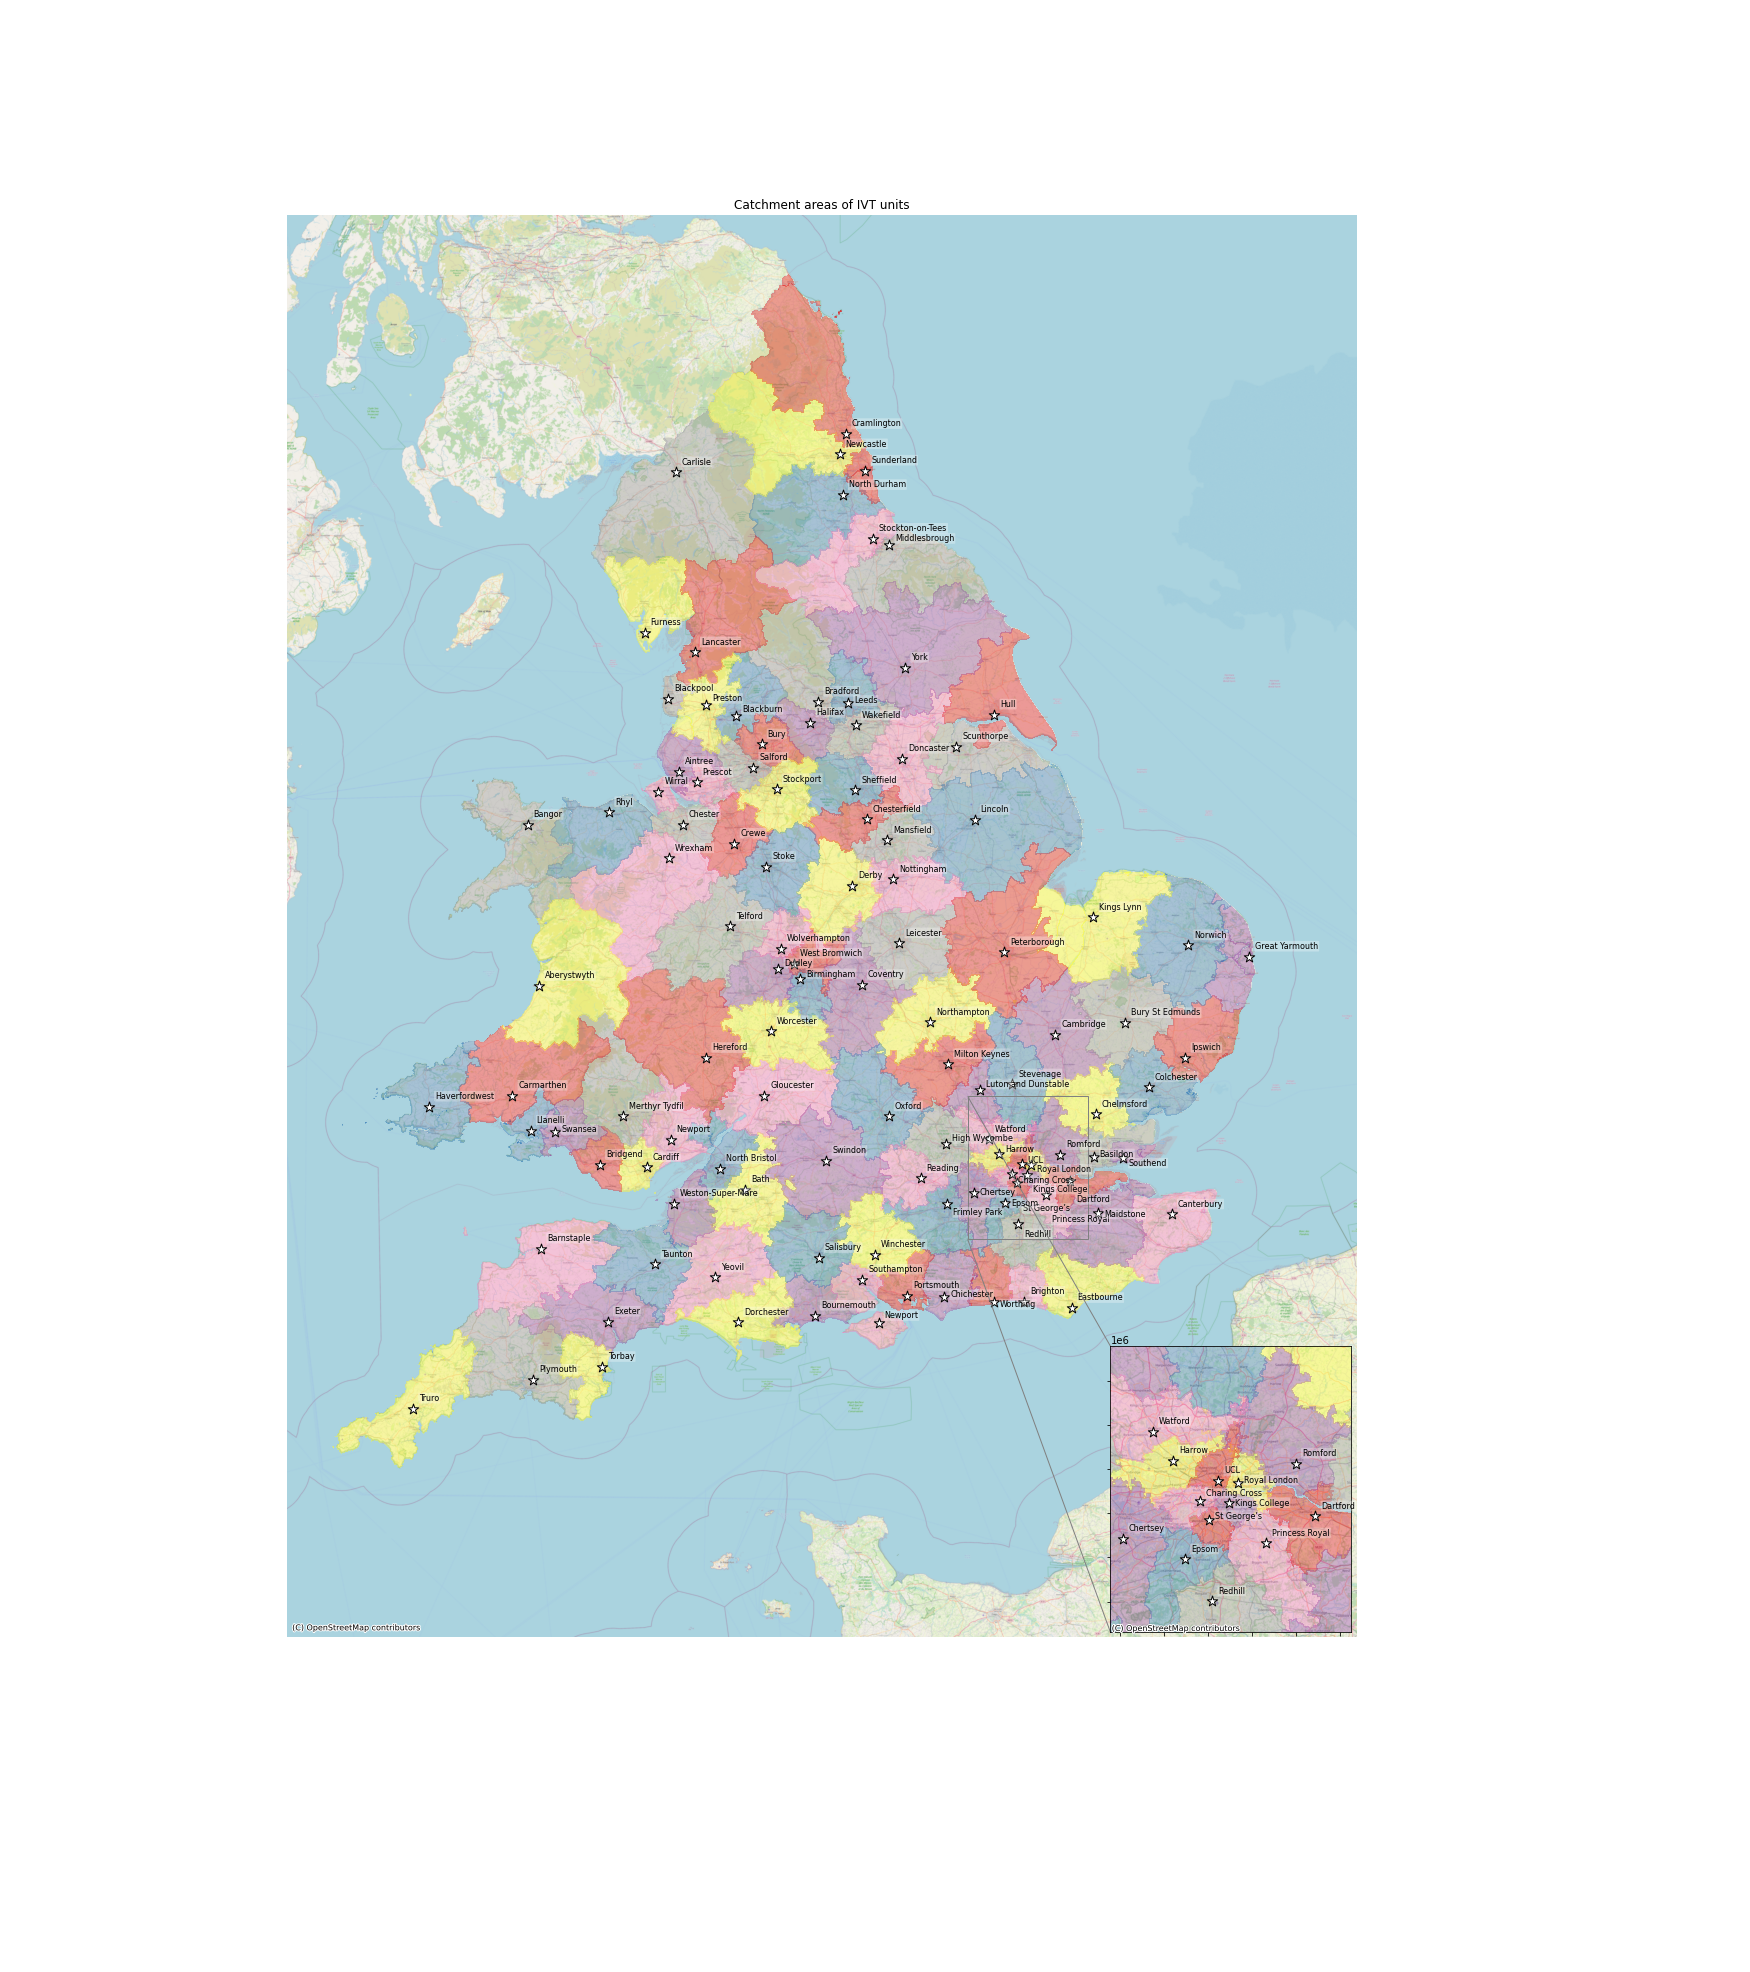

In [17]:
show_labels = True

title = 'Catchment areas of IVT units'

# unique color way
dlen = gdf_ivt_catchment.shape[0]

cd = dict.fromkeys(range(dlen))
for i in range(dlen):
    # colors
    r = random.uniform(0,1)
    g = random.uniform(0,1)
    b = random.uniform(0,1)
    color = (r, g, b)
    cd[i] = color
color_dict = cd

# plot map
fig, ax = plt.subplots(figsize=(15, 20)) # Make max dimensions 10x10 inch
gdf_ivt_catchment.plot(ax=ax, # Set which axes to use for plot (only one here)
                       column="greedy_dist1",
                       categorical=True,
                        cmap="Set1",
#                    legend=True,
 #                 column=col, # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='none', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 vmin=0, # Manual scale min (remove to make automatic)
#                 vmax=70, # Manual scale max (remove to make automatic)
#                 cmap=colors.ListedColormap(list(color_dict.values())),  
                # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':f'{title}'},
                 # Set to display legend
#                 legend=True,
                 # Set transparancy (to help reveal basemap
                 alpha = 0.4)

# Plot location of hospitals
gdf_units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

if show_labels:
    ax = add_nonoverlapping_text_labels(gdf_units, ax, 'hospital_city',
                                        y_step=0.05, fontsize=8)
        
# give some more space at bottom for london inset map
ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])
# give some more space at right for hospital name label
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Insert an inset map (loc=4 places it bottom right)
axins = zoomed_inset_axes(ax, 2, loc=4)

# Identify london hospitals to go in the inset map
mask = gdf_units["Strategic Clinical Network"]=="London SCN"
london_hospitals = gdf_units["Hospital_name"][mask].to_list()

# identify map area to plot in the inset map
# initialise exteme values
minx_ = np.inf
miny_ = np.inf
maxx_ = 0
maxy_ = 0
# Find min and max x and y for the london hospitals
for h in london_hospitals:
    index,minx,miny,maxx,maxy = eng_wales_bounds.loc[h]
    minx_ = min(minx_, minx)
    miny_ = min(miny_, miny)
    maxx_ = max(maxx_, maxx)
    maxy_ = max(maxy_, maxy)

# Set extent of inset map
axins.set_xlim(minx_, maxx_)
axins.set_ylim(miny_, maxy_)

# Define lines connecting inset map to main map
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# Plot zoom window
gdf_ivt_catchment.plot(ax=axins, # Set which axes to use for plot (only one here)
                       column="greedy_dist1",
                       categorical=True,
                        cmap="Set1",
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='none', # Make LSOA boundry same colour as area
                 linewidth=0.0,# Use linewidth=0 to hide boarder lines
#                 cmap=colors.ListedColormap(list(color_dict.values())),  
                 legend_kwds={'shrink':0.5, 'label':f'{title}'},
                 alpha = 0.4)

# Plot location of hospitals
gdf_units.plot(ax=axins, edgecolor='k', facecolor='w', markersize=120, 
               marker='*')

# Label hospitals
if show_labels:
    axins = add_nonoverlapping_text_labels(gdf_units, axins, 'hospital_city',
                                        y_step=0.05, fontsize=8)

# Add base map (note that we specifiy the same CRS as we are using)
# Use manual zoom to adjust level of detail of base map
ctx.add_basemap(ax=axins, 
                source=ctx.providers.OpenStreetMap.Mapnik,zoom=10)

# Remove x and y ticks
plt.setp(axins.get_xticklabels(), visible=False)
plt.setp(axins.get_yticklabels(), visible=False)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_axis_off() # Turn of axis line and numbers
ax.set_title(f'{title}')
# Adjust for printing
ax.margins(0)
ax.apply_aspect()
plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
filename = 'map_ivt_catchments.jpg'
plt.savefig(filename, dpi=300) # Save figure
plt.show()

Area in km2
https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

In [18]:
shapefile_copy = gdf_ivt_catchment.copy()
shapefile_copy = shapefile_copy.to_crs({'init': 'epsg:3857'})
shapefile_copy["area"] = shapefile_copy.area / 10**6

/home/kerry/anaconda3/envs/geopandas/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
col = "area"
col_readable = "area (km2)"
print(f"The range of {col_readable} across the {shapefile_copy.shape[0]} catchments is: {round(shapefile_copy[col].min(),2)} to {round(shapefile_copy[col].max(),2)}")
print(f"Median: {round(shapefile_copy[col].median(),2)}")

The range of area (km2) across the 113 catchments is: 204.16 to 13940.49
Median: 2997.52


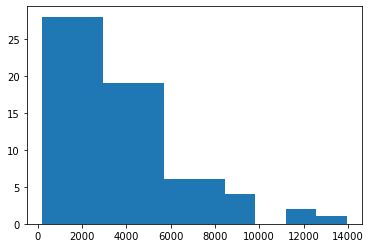

In [20]:
plt.hist(shapefile_copy[col]);

In [ ]:
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)
df_lsoa.set_index(['closest_iv'], inplace=True)

gdf_ivt_catchment = gdf_ivt_catchment.join(gdf_units['ivt_rate'].astype(float)).reset_index()
gdf_ivt_catchment.head()

'population_density'
